In [11]:
import qiskit
from qiskit import quantum_info
#from qiskit.execute_function import execute
from qiskit_aer import AerSimulator
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from PIL import Image
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
from PIL import Image
import matplotlib.pyplot as plt
import sys
from qiskit.visualization import plot_histogram, plot_distribution




import matplotlib.image as img
# from qiskit import *
# from qiskit import IBMQ
# from qiskit.compiler import transpile, assemble
# from qiskit.tools.jupyter import *
# from qiskit.visualization import *

This cell is the procedure the orginisers(last year) suggested participants go by.

In [ ]:
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(255*image1,255*image2)

In [ ]:
data_path='./data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, shuffle=False
)

# #you can visualize it
import matplotlib.pyplot as plt
index = 0
for i in range(len(train_images)):
    img = train_images[index]
    #plt.imshow(img)
    mag_img = np.sqrt(np.sum(img**2))
    norm_img = np.sum(img/mag_img)
    #print(np.where(norm_img==np.nan))
    print(mag_img)
    index += 1

In [4]:
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 0, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

image_path = '/workspaces/QC/murat.jpeg'  # Specify the path to your image file
image1 = img.imread(image_path)[:,:,2].reshape(275,183)
# plt.imshow(image1, cmap='gray', interpolation='nearest')
# plt.show()
image1


array([[ 46,  46,  46, ...,  37,  37,  37],
       [ 47,  47,  47, ...,  37,  37,  37],
       [ 48,  48,  48, ...,  37,  37,  37],
       ...,
       [ 71,  71,  71, ...,  93,  88, 129],
       [ 71,  71,  71, ...,  98, 116, 179],
       [ 71,  71,  71, ...,  97, 117, 186]], dtype=uint8)

In [5]:
def amplitude_encode(img_data):
    # Calculate the RMS value
    img_w, img_h = img_data.shape[0], img_data.shape[1]
    # print('--------',img_data.shape[0])
    pixel_num = img_w*img_h
    norm_img = img_data/np.max(img_data)
    norm_sq = norm_img**2
    norm_sq_sum = np.sum(norm_sq)
    norm_sq_sum_root = np.sqrt(norm_sq_sum)

    temp = norm_img/norm_sq_sum_root
    print(np.sum(temp**2))

    return temp.reshape(pixel_num), norm_sq_sum_root, pixel_num

test_img = np.array((1,1,1,9,1,9876549,1,1,678,1)).reshape(5,2)
amplitude_encoded, rms, pixel_num = amplitude_encode(image)

1.0


Probabilities dict from statevector:  {}


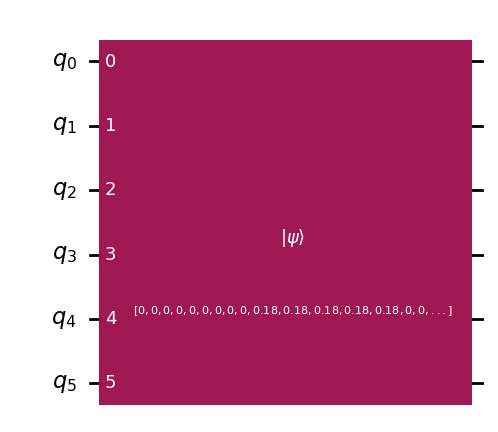

In [53]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

num_q = num_qubits = int(np.log2(pixel_num))
qc= QuantumCircuit(num_q)
qc.initialize(amplitude_encoded)

#qc.measure_all()
# result = AerSimulator().run(qc).result()
# statistics = result.get_counts(qc)
# # display(plot_histogram(statistics))

# amplitudes = np.array(list(dict(statistics).values()))
# amplitudes2 = amplitudes/np.sum(amplitudes)
# np.sum(amplitudes2)
#  = amplitudes2**2
# np.sum(probabilities)


sv = Statevector.from_instruction(qc).probabilities_dict(decimals=1)
print('Probabilities dict from statevector: ', sv)
qc.draw('mpl')

Depth:  3
Probabilities dict from statevector:  {'000': 0.5, '111': 0.5}


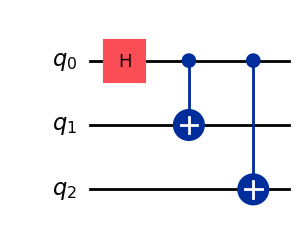

In [51]:
three_ghz = QuantumCircuit(3)
three_ghz.h(0)
three_ghz.cx(0,1)
three_ghz.cx(0,2) #alternativelya, you can use a cnot/cx gate here with qubit 1 (control) and qubit 2 (target)
depth = three_ghz.depth()
sv = Statevector.from_instruction(three_ghz).probabilities_dict(decimals=1)
print('Depth: ', depth)
print('Probabilities dict from statevector: ', sv)
three_ghz.draw('mpl')

In [7]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

# def understand_np_dot_roll():
#     arr = np.random.randint(1, 9, 16).reshape(4,4) * np.identity(4)
#     print("Random matrix generated\n", arr)
#     print("Shifting image by 1 in axis=1(x-axis)\n", np.roll(arr, 1, axis=1))
#     print("Shifting image by 1 in axis=1(x-axis) and by 1 in axis=0(y-axis) \n", np.roll(arr, (1,1), axis=(0,1)))
# understand_np_dot_roll()

In [ ]:
#submission to part 1, you should make this into a .py file
n=len(images)
mse=0
gatecount=0
num_qubits = 8


def plot_image(img, title='Reconstructed image'):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
def encode(image):
    image_norm_h, rms, pixel_num = amplitude_encode(image)
    num_qubits = int(np.log2(pixel_num))
    print(f"{num_qubits} initialised for this image")
    qc_h = QuantumCircuit(num_qubits)
    qc_h.initialize(image_norm_h, range(0, num_qubits))
    return qc_h, rms, num_qubits

def simulate(circuit, show_histogram=True):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    statevector = result.get_statevector()
    probabilities = np.array(np.abs(statevector)**2)
    if show_histogram:
        plt.bar(range((2**circuit.num_qubits)), probabilities)
        plt.xlabel('Basis State')
        plt.ylabel('Probability')
        plt.show()
    return probabilities

def decode(probabilities, rms):
    prob_sqrt = np.sqrt(probabilities)
    reconstructed_image = prob_sqrt * rms
    dim = int(np.sqrt(len(reconstructed_image)))
    return reconstructed_image.reshape(dim, dim)

def run_part1(image):
    #encode image into a circuit
    circuit, rms, num_qubits = encode(image)

    #simulate circuit
    histogram=simulate(circuit, show_histogram=False)

    #reconstruct the image
    image_re=decode(histogram, rms)

    return circuit,image_re, num_qubits 

def resize_iamges(dataset, resized_dimention=16):
    temp_dataset = np.empty((dataset.shape[0], resized_dimention, resized_dimention))
    for index,img in dataset:
        img = Image.fromarray(img)
        img = np.array(img.resize((resized_dimention, resized_dimention)))
        temp_dataset[index] = img
    return temp_dataset




qubits_list = list(range(num_qubits))
feature_map = ZFeatureMap(num_qubits)  # initialise feature map to capture total pixels

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), qubits=list(range(8)), inplace=True)
# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)
   

#print(ansatz.parameters)
circuit.compose(feature_map, range(8), inplace=True)
#circuit.append(feature_map, range(num_qubits))
circuit.compose(ansatz, range(8), inplace=True)
#circuit.append(ansatz, range(num_qubits))

#circuit.decompose().draw("mpl", fold=-1)

# circuit2, test_image2 = run_part1(img.T)
#plot_image(test_image)

In [ ]:
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=10),  # Set max iterations here
    callback=callback_graph
)

In [ ]:
train_images = resize_images(train_images, resized_dimention=16)
test_images = resize_images(test_images, resized_dimention=16)

classifier.fit(train_images, train_labels)

plt.rcParams["figure.figsize"] = (12, 6)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [ ]:
#how we grade your submission

n=len(images)
mse=0
gatecount=0

for data in images:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

In [ ]:
def conv_circuit(params):
    """
    params is a parameter vector
    """
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# # Let's draw this circuit and see what it looks like
# params = ParameterVector("θ", length=3)
# circuit = conv_circuit(params)
# circuit.draw("mpl")

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
        #print('qi',q1,'q2',q2)
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# circuit = conv_layer(4, "θ")
# circuit.decompose().draw("mpl", fold=100)


def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# params = ParameterVector("θ", length=3)
# circuit = pool_circuit(params)
# circuit.draw("mpl")


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# sources = [0, 1] # qubits from which information will be 'transferred'
# sinks = [2, 3] #qubits to which transferred information will be encoded
# circuit = pool_layer(sources, sinks, "θ")
# circuit.decompose().draw("mpl")